##### Knut Dundas Morå, knut.mora@uzh.ch, 241120

### Using code from "Harmonizing discovery thresholds and reporting two-sided confidence intervals: a modified Feldman & Cousins method"
[Paper on arxiv.org](https://arxiv.org/pdf/1809.02024)

In [ ]:
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo

try:
    from tqdm import tqdm
except:
    tqdm = lambda x:x

# Searching for a line signature-- profiling and likelihood ratios
- profiling, 
- discovery significance,
- nonasymptotic distributions

#### Some useful functions to save us time: 

These functions define the PDFs we will use to define our measurement. 

Our model consists of two components: 

 - A power-law background $\propto E^{-\gamma}$, where $\mu_\text{bkg}$ events are expected
 - A Gaussian signal $\propto e^{-(E-m)^2 / (2\cdot \sigma^2)}$, where $\mu_\text{sig}$ events are expected
 - where the normalisations are chosen so that the PDFs are defined between the lower and upper energy range $E_0$ and $E_1$ 



Illustration of a power-law with some gaussian signal examples on top of a 
 





#### Some useful functions to save us time: 

These functions define the PDFs we will use to define our measurement. 

Our model consists of two components: 

 - A power-law background $\propto E^{-\gamma}$, where $\mu_\text{bkg}$ events are expected
 - A Gaussian signal $\propto e^{-(E-m)^2 / (2\cdot \sigma^2)}$, where $\mu_\text{sig}$ events are expected
 - where the normalisations are chosen so that the PDFs are defined between the lower and upper energy range $E_0$ and $E_1$


Parameters of the model are:
  - $E_0, E_1$, `E0, E1`-- the lower and upper limit of the energy range considered 
  - $\mu_\text{bkg}$, `mu_bkg` -- the number of expected background events
  - $\gamma$, `gamma` -- the power-law index of the background distribution, we'll set this to -2 
  - $\mu_\text{sig}$, `mu_sig`-- the expected number of signal events
  - $m$, `m`-- the energy at which the line signal is expected
  - $\sigma$, `sigma`-- the width of the line signal-- unless specified, we'll set this to $0.1\cdot m$
 
In the following, I'll provide some functions and some function skeletons to get you started-- please make sure to check if one can be used before making your own! 


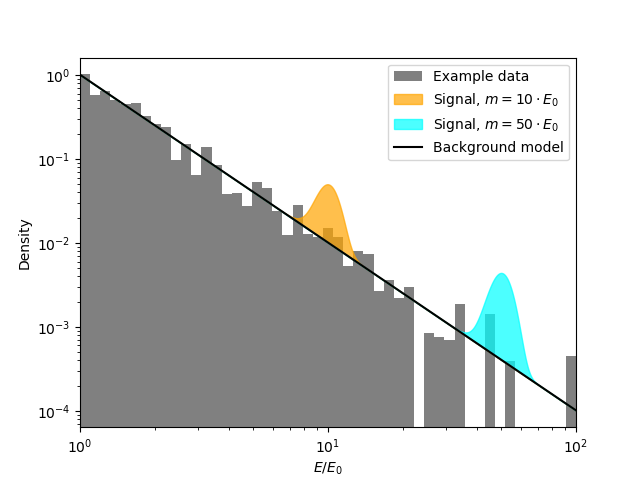

Illustration of a power-law with some gaussian signal examples on top of a power-law background

In [ ]:
# power-law background: functions to: - compute the probability, and compute the inverse cumulative density
# in order to generate random numbers distributed according to a power law

def power_law(E,gamma):
    """
    Power-law-- gamma is less than -1, and represents the typical falling spectra seen in astrophysics (often -2.7)
    or similar
    """
    return E**gamma
def power_law_integral(E0,E1,gamma):
    """
    Integral of a power-law from E0 to E1 with power gamma
    """
    return (E1**(1+gamma)-E0**(1+gamma))/(1+gamma)

def power_law_normed(E,gamma,E0,E1):
    """
    Probability density evaluated at E for a power-law defined between E0 and E1
    """
    return power_law(E,gamma)/power_law_integral(E0,E1,gamma)

def power_law_integral_normed(E,gamma,E0,E1):
    """
    The CDF of the power law
    """
    return power_law_integral(E,gamma,E0)/power_law_integral(E0,E1,gamma)

def power_law_invcdf(t,gamma,E0,E1):
    """
    Inverse cumulative integral-- we can use this to generate random numbers from the power law
    """
    g=gamma+1
    return (t*(E1**g-E0**g)+E0**g)**(1/g)

def power_law_generate_random(N,gamma,E0,E1):
    """
    Generate N random numbers from a power law defined between E0 and E1 with power index gamma
    """
    return power_law_invcdf(sps.uniform().rvs(N),gamma,E0,E1)


# a Gaussian signal: 


def gaussian_invcdf(t,m,sigma,E0,E1):
    """
    If the Gaussian is close to the domain boundaries, the normalisation is not guaranteed-- 
    lets enforce it explicitly
    """
    dist = sps.norm(m,sigma)
    cdf = dist.cdf
    ppf = dist.ppf
    return ppf(t*(cdf(E1)-cdf(E0))+cdf(E0))

def gaussian_normed(E,m, sigma,E0,E1):
    """
    Gaussian PDF including if the limits are close to our region
    """
    if 3*sigma<(m-E0) or 3*sigma<(E1-m):
        d = sps.norm(m,sigma)
        return d.pdf(E) / (d.cdf(E1) - d.cdf(E0))
    else:
        return sps.norm(m,sigma).pdf(E)

def gaussian_generate_random(N,m,sigma,E0,E1):
    """
    Generate random data using the inverse of the cumulative distribution
    """
    if 3*sigma<(m-E0) or 3*sigma<(E1-m):
        return gaussian_invcdf(sps.uniform().rvs(N),m,sigma,E0,E1)
    else:
        return sps.norm(m,sigma).rvs(N)
    
def generate_data(mu_sig, mu_bkg, m,sigma, E0,E1, gamma):
    """
    Generate a simulated observed dataset for a given signal and background expectation, 
    signal location and width
    normalisation boundaries, 
    and power law index: 
    """
    r_bkg = power_law_generate_random(sps.poisson(mu_bkg).rvs(),gamma,E0,E1)
    r_sig = gaussian_generate_random(sps.poisson(mu_sig).rvs(),m,sigma,E0,E1)
    return np.concatenate([r_bkg, r_sig])

    


## 0: Optimisation 

scipy.optimize.minimize (or iminuit if you prefer) will be our bread-and-butter  
The key trick is to remember how to set up the function to be used: 

In [ ]:
def function_scipy(x, a=0.5, b=1):
    #if 0<a, this function has a global minimum at 0,0, but if a is close to 0, this minimum will have a broad near-flat part near y=x**2    
    #note that only parameters inside the vector x are minimized for-- the rest are fixed parameters. 
    return x[0]**2 + b*(x[1]-a*x[0]**2)**4 

In [ ]:
#minimize using scipy: 
scipy_result = spo.minimize(function_scipy, [3, 9.2], args=(0.5,1)) #notice that you have to provide a guess for "x"
#and that you can pass further args like a,b to the minimizer
print(scipy_result)

## Step 1: write out the likelihood! 


Because the scipy.optimize interface is a bit fiddly, I have already written the function structure. 

`minusloglikelihood` is the function where the likelihood is returned for a certain dataset `data`-- the dataset will be a numpy array of energies. `likelihood_with_fixed_signal` is a function to help using the minimiser if you need to hold the signal fixed. 

### Exercise 1: edit the function to represent our statistical model of our experiment: 

Our likelihood is an _extended unbinned likelihood_ 


***Read the following implementation and write out the likelihood in standard math-formalism that the code represents: ***

In [ ]:
def minusloglikelihood(x , data, m, sigma, gamma, E0,E1):
    """
    Define likelihood as function of  x where X is: 
    x[0] = signal rate
    x[1] = background rate
    """
    
    mu_sig = x[0]
    mu_bkg = x[1]
    mu_tot = mu_sig + mu_bkg
    
    ret = (mu_bkg/mu_tot)*power_law_normed(data, gamma,E0,E1)
    ret += (mu_sig/mu_tot)*gaussian_normed(data, m,sigma,E0,E1)
    ret = np.sum(np.log(ret)) + sps.poisson(mu_tot).logpmf(len(data))    
    
    return -1*ret # our optimisers look for minima, so to maximise the likelihood we multiply by -1
    
    

def minusloglikelihood_with_fixed_signal(y, signal, data, m, sigma, gamma, E0,E1):
    return likelihood([signal,y[0]], data, m,sigma,gamma,E0,E1)

## Step 2: Fit the likelihood!

Now that we have a likelihood object, lets have fun!

Here are some parameters we'll choose as "true" to start with: 

  - Energy range between 10 and 1000 
  - gamma of -2
  - mass your choice between the energy extremes 
  - sigma = 0.1*mass



***Run the below cell a couple of times-- do the best-fit parameters make sense to you?***



In [ ]:
E0 = 10
E1 = 1000
gamma = -2
m = 20
sigma = 0.1*m

mu_sig = 50
mu_bkg = 500
#generate your data here! 

data = generate_data(mu_sig, mu_bkg, m, sigma, E0,E1, gamma)




fixed_args = [data, m, sigma, gamma, E0,E1]
fit_result = spo.minimize(minusloglikelihood, [1,len(data)], args=tuple(fixed_args), bounds=((0,np.inf),(0,np.inf)))

print(fit_result)

### Step 3: What to do about nuisance parameters?

It is very common that we're much more interested in a few parameters of our model-- those that express interesting new physics than the rest. In our case, $\mu_\text{sig}$ is of great interest, while $\mu_\text{bkg}$ is less so. In frequentist statistics, we commonly deal with this issue by _profiling_ -- for each value of the signal we wish to test, we set $\mu_\text{bkg}$ to the value that optimises the likelihood given that signal

***Use minusloglikelihood_with_fixed_signal to compute the profiled likelihood for signal expectation values between 0 and 100, and plot the profile log-likelihood curve***

###  Step 4: Compute the distribution of the "discovery test statistic"

When we wish to discover a new signal, we formulate that as a hypothesis test of the background-only hypothesis. 

In the previous step, that corresponds to evaluating the profiled log-likelihood _at signal=0_ 
However, this profiled log-likelihood is not normalised-- a better test statistic is finding the ratio between the profiled log-likelihood and the global best-fit, making the _log-likeliood ratio_: 

$\lambda(s) = -2 \text{log}[  \frac{\mathcal{L}(s, \hat{\hat{\mu_\text{bkg}}} )}{\mathcal{L}(\hat{s}, \hat{\mu_\text{bkg}} )} ]$

Here, $\hat{\hat{\mu_\text{bkg} }}$ is the background expectation that optimises the likelihood for a given fixed s, while $\hat{s}, \hat{\mu_\text{bkg}}$ is the values of signal and background that optimises the likelihood in full. 

The distribution of this test statistic is what we'll use to assess an eventual discovery. 

***Generate 1000 random datasets with no signal, and for signal mass of 100, compute the profiled log-likelihood ratio for each, and plot them as a histogram***

In [ ]:
#compute the llr disttribution here

In [ ]:
plt.clf()
x = np.linspace(0,20,1001)

plt.hist(llr, bins=100, cumulative=-1, density=True, label="ToyMCs")
plt.plot(x, 0.5*sps.chi2(1).sf(x), label="Theoretical prediction")
plt.yscale("log")
plt.xlabel("$\lambda(s)$")
plt.ylabel("Fraction of events below $\lambda$")
plt.legend()
plt.show()

### Step 5: more investigations
***Repeat step4, but with a few different signal masses-- try out 20, 100, 500 at least-- what do you see?***
